In [1]:
import pandas as pd
import numpy as np
import gc
from sklearn.metrics import roc_auc_score


In [2]:
import pickle
import gensim
ff = open('../w2vmodel/w2vec.pkl','rb')  ##word2vec模型
w2vec = pickle.load(ff)
ff.close()

In [3]:
aid2idx = {aid: i for i, aid in enumerate(w2vec.wv.index_to_key)}

In [4]:
w2vec.wv[1460571]

array([ 0.60642844, -0.7237697 ,  0.03179833,  1.3538103 , -0.14561307,
        0.38078773,  0.0075475 ,  0.29055348,  0.11041994,  0.01257462,
        0.2169771 , -0.06168181, -0.74419105,  0.69866025,  0.2021049 ,
        0.6940198 , -0.21829714,  0.4832874 ,  0.2439045 ,  0.8554348 ,
        0.86980444,  0.54105246,  0.39540333, -0.7028183 ,  0.00156603,
        0.5302937 ,  0.17863704,  0.9127092 , -0.14084946, -0.33976895,
       -0.26613307,  0.5729116 ,  0.79114884, -0.6285883 ,  0.11908115,
        0.34329572,  0.13732255,  0.15042329,  0.85755855, -0.29543757,
        0.08415931,  0.7656158 , -0.2707001 , -0.08153496,  0.01528863,
        0.57353556,  0.6630349 , -0.27493155,  1.3147256 ,  0.25140536,
       -0.54878384, -0.09320769,  0.51105773,  0.95633924,  0.8307247 ,
        0.6422468 ,  0.02433391, -0.29257485, -0.69384015, -0.11217391,
        0.22190516,  0.5671127 ,  0.12656885,  0.37216824], dtype=float32)

In [2]:
t = 'orders'
# t = 'carts'
# t = 'clicks'

train = pd.read_parquet(f'valid_label_{t}.pqt')


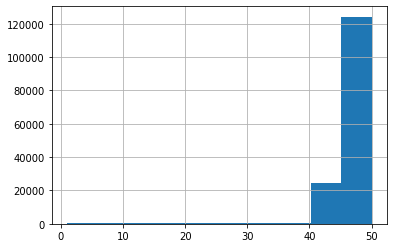

In [3]:
train[train.flag==1].groupby('session')['aid'].count().hist()

In [4]:
train

,aid,rank,flag,session,type,label
0,11830,0.0,1.0,11098528,orders,1.0
1,1732105,1.0,1.0,11098528,orders,0.0
2,588923,2.0,1.0,11098528,orders,0.0
3,884502,3.0,1.0,11098528,orders,0.0
4,1157882,4.0,1.0,11098528,orders,0.0
...,...,...,...,...,...,...
7350451,409401,46.0,1.0,12899525,orders,0.0
7350452,1843621,47.0,1.0,12899525,orders,0.0
7350453,328678,48.0,1.0,12899525,orders,0.0
7350454,672619,49.0,1.0,12899525,orders,0.0


In [5]:
train.session.nunique()

150817

In [10]:
ff = open(f'ww1clicks.pkl','rb')
ww1 = pickle.load(ff)
ff.close()
ff = open(f'ww2carts.pkl','rb')
ww2 = pickle.load(ff)
ff.close()
ff = open(f'ww3orders.pkl','rb')
ww3 = pickle.load(ff)
ff.close()


In [11]:
from multiprocessing import Pool

def f(ii):
    try:
        return np.corrcoef(w2vec.wv[train.loc[ii,'aid']],ww1[train.loc[ii,'session']])[0][1]
    except:
        return np.nan


In [16]:
##计算相似性的函数
def calc_corr2(tmp,ww): 
    tmp['vec1'] = [ww[xx] if xx in ww else np.array([0]*64) for xx in tmp.session]
    tmp['vec2'] = [w2vec.wv[xx] if xx in w2vec.wv else np.array([0]*64) for xx in tmp.aid]
    tmp['vec1mean'] =  np.mean(np.concatenate(tmp.vec1,axis=0).reshape(-1,64),axis=1)
    tmp['vec2mean'] = np.mean(np.concatenate(tmp.vec2,axis=0).reshape(-1,64),axis=1)

    tmp['vec12'] = (tmp['vec1']-tmp['vec1mean'])*(tmp['vec2']-tmp['vec2mean'])
    tmp['vec11'] = (tmp['vec1']-tmp['vec1mean'])*(tmp['vec1']-tmp['vec1mean'])
    tmp['vec22'] = (tmp['vec2']-tmp['vec2mean'])*(tmp['vec2']-tmp['vec2mean'])
    v12 = np.concatenate(tmp.vec12,axis=0).reshape(-1,64)
    v11 = np.concatenate(tmp.vec11,axis=0).reshape(-1,64)
    v22 = np.concatenate(tmp.vec22,axis=0).reshape(-1,64)
    sssss1 = np.mean(v12,axis=1)/np.sqrt(np.mean(v11,axis=1)*np.mean(v22,axis=1))
    return sssss1

In [17]:
from multiprocessing import Pool
import numpy as np
##并行
def f(ii):
    return calc_corr2(train[ii*10000:(ii+1)*10000].reset_index(drop=True),ww1)
from tqdm import tqdm 
with Pool(10) as p:
    sss1 = list(tqdm(iterable=(p.imap(f, range(int(len(train)/10000)+1))), total=int(len(train)/10000)+1))
train['sim_clicks'] = np.concatenate(sss1)

  0%|          | 0/736 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
  0%|          | 1/736 [00:00<07:08,  1.72it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWa

In [18]:

def f(ii):
    return calc_corr2(train[ii*10000:(ii+1)*10000].reset_index(drop=True),ww2)
from tqdm import tqdm 
with Pool(10) as p:
    sss1 = list(tqdm(iterable=(p.imap(f, range(int(len(train)/10000)+1))), total=int(len(train)/10000)+1))
train['sim_carts'] = np.concatenate(sss1)

  0%|          | 0/736 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide

In [19]:

def f(ii):
    return calc_corr2(train[ii*10000:(ii+1)*10000].reset_index(drop=True),ww3)
from tqdm import tqdm 
with Pool(10) as p:
    sss1 = list(tqdm(iterable=(p.imap(f, range(int(len(train)/10000)+1))), total=int(len(train)/10000)+1))
train['sim_orders'] = np.concatenate(sss1)

  0%|          | 0/736 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide

In [20]:
ff = open(f'ww1clicks_last1.pkl','rb')
ww1_last1 = pickle.load(ff)
ff.close()
ff = open(f'ww2carts_last1.pkl','rb')
ww2_last1 = pickle.load(ff)
ff.close()
ff = open(f'ww3orders_last1.pkl','rb')
ww3_last1 = pickle.load(ff)
ff.close()


In [21]:

def f(ii):
    return calc_corr2(train[ii*10000:(ii+1)*10000].reset_index(drop=True),ww1_last1)
from tqdm import tqdm 
with Pool(10) as p:
    sss1 = list(tqdm(iterable=(p.imap(f, range(int(len(train)/10000)+1))), total=int(len(train)/10000)+1))
train['sim_clicks_last1'] = np.concatenate(sss1)



def f(ii):
    return calc_corr2(train[ii*10000:(ii+1)*10000].reset_index(drop=True),ww2_last1)
from tqdm import tqdm 
with Pool(10) as p:
    sss2 = list(tqdm(iterable=(p.imap(f, range(int(len(train)/10000)+1))), total=int(len(train)/10000)+1))
train['sim_carts_last1'] = np.concatenate(sss2)



def f(ii):
    return calc_corr2(train[ii*10000:(ii+1)*10000].reset_index(drop=True),ww3_last1)
from tqdm import tqdm 
with Pool(10) as p:
    sss3 = list(tqdm(iterable=(p.imap(f, range(int(len(train)/10000)+1))), total=int(len(train)/10000)+1))
train['sim_orders_last1'] = np.concatenate(sss3)

  0%|          | 0/736 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
  0%|          | 1/736 [00:00<07:04,  1.73it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
  0%|          | 3/736 [00:00<02:31,  4.85it/s]/usr/local/lib/python3.6/di

In [23]:
##用户的上N次点击

ff = open(f'ww1clicks_last2.pkl','rb')
ww1_last2 = pickle.load(ff)
ff.close()


def f(ii):
    return calc_corr2(train[ii*10000:(ii+1)*10000].reset_index(drop=True),ww1_last2)
from tqdm import tqdm 
with Pool(10) as p:
    sss1 = list(tqdm(iterable=(p.imap(f, range(int(len(train)/10000)+1))), total=int(len(train)/10000)+1))
train['sim_clicks_last2'] = np.concatenate(sss1)


ff = open(f'ww1clicks_last3.pkl','rb')
ww1_last3 = pickle.load(ff)
ff.close()
def f(ii):
    return calc_corr2(train[ii*10000:(ii+1)*10000].reset_index(drop=True),ww1_last3)
from tqdm import tqdm 
with Pool(10) as p:
    sss1 = list(tqdm(iterable=(p.imap(f, range(int(len(train)/10000)+1))), total=int(len(train)/10000)+1))
train['sim_clicks_last3'] = np.concatenate(sss1)



ff = open(f'ww1clicks_last5.pkl','rb')
ww1_last5 = pickle.load(ff)
ff.close()
def f(ii):
    return calc_corr2(train[ii*10000:(ii+1)*10000].reset_index(drop=True),ww1_last5)
from tqdm import tqdm 
with Pool(10) as p:
    sss1 = list(tqdm(iterable=(p.imap(f, range(int(len(train)/10000)+1))), total=int(len(train)/10000)+1))
train['sim_clicks_last5'] = np.concatenate(sss1)


ff = open(f'ww1clicks_last10.pkl','rb')
ww1_last10 = pickle.load(ff)
ff.close()
def f(ii):
    return calc_corr2(train[ii*10000:(ii+1)*10000].reset_index(drop=True),ww1_last10)
from tqdm import tqdm 
with Pool(10) as p:
    sss1 = list(tqdm(iterable=(p.imap(f, range(int(len(train)/10000)+1))), total=int(len(train)/10000)+1))
train['sim_clicks_last10'] = np.concatenate(sss1)


  0%|          | 0/736 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
  0%|          | 1/736 [00:00<08:23,  1.46it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWa

In [26]:
train.columns

Index(['aid', 'rank', 'flag', 'session', 'type', 'label', 'sim_clicks',
       'sim_carts', 'sim_orders', 'sim_clicks_last1', 'sim_carts_last1',
       'sim_orders_last1', 'sim_clicks_last2', 'sim_clicks_last3',
       'sim_clicks_last5', 'sim_clicks_last10'],
      dtype='object')

In [5]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [8]:
train.shape

(7350456, 6)

In [9]:
user_features = pd.read_parquet('user_features.pqt').reset_index()
item_features = pd.read_parquet('item_features.pqt').reset_index()
user_item_features = pd.read_parquet('user_item_features.pqt').reset_index()

In [11]:
item_features.columns

Index(['aid', 'item_count', 'item_user_count', 'item_buy_ratio',
       'item_clicks_count', 'item_clicks_user_count', 'item_carts_count',
       'item_carts_user_count', 'item_orders_count', 'item_orders_user_count'],
      dtype='object')

In [13]:
item_features

,aid,item_count,item_user_count,item_buy_ratio,item_clicks_count,item_clicks_user_count,item_carts_count,item_carts_user_count,item_orders_count,item_orders_user_count
0,0,38,30,1.000000,38.0,30.0,NaN,NaN,NaN,NaN
1,1,32,29,1.156250,31.0,28.0,1.0,1.0,NaN,NaN
2,2,16,15,1.000000,16.0,15.0,NaN,NaN,NaN,NaN
3,3,1525,852,1.327213,1415.0,852.0,93.0,80.0,17.0,16.0
4,4,148,103,1.168919,143.0,103.0,5.0,5.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1844279,1855598,7,7,1.000000,7.0,7.0,NaN,NaN,NaN,NaN
1844280,1855599,9,8,1.000000,9.0,8.0,NaN,NaN,NaN,NaN
1844281,1855600,70,44,1.242857,66.0,44.0,3.0,3.0,1.0,1.0
1844282,1855601,92,62,1.380435,85.0,60.0,7.0,7.0,NaN,NaN


In [14]:
user_features

,session,user_count,user_item_count,user_buy_ratio,user_clicks_count,user_clicks_item_count,user_carts_count,user_carts_item_count,user_orders_count,user_orders_item_count
0,11098528,1,1,1.000000,1.0,1.0,NaN,NaN,NaN,NaN
1,11098529,1,1,1.000000,1.0,1.0,NaN,NaN,NaN,NaN
2,11098530,6,2,1.833333,5.0,2.0,1.0,1.0,NaN,NaN
3,11098531,24,11,1.333333,20.0,11.0,NaN,NaN,4.0,4.0
4,11098532,2,2,1.000000,2.0,2.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1801246,12899774,1,1,1.000000,1.0,1.0,NaN,NaN,NaN,NaN
1801247,12899775,1,1,1.000000,1.0,1.0,NaN,NaN,NaN,NaN
1801248,12899776,1,1,1.000000,1.0,1.0,NaN,NaN,NaN,NaN
1801249,12899777,1,1,1.000000,1.0,1.0,NaN,NaN,NaN,NaN


In [15]:
item_features

,aid,item_count,item_user_count,item_buy_ratio,item_clicks_count,item_clicks_user_count,item_carts_count,item_carts_user_count,item_orders_count,item_orders_user_count
0,0,38,30,1.000000,38.0,30.0,NaN,NaN,NaN,NaN
1,1,32,29,1.156250,31.0,28.0,1.0,1.0,NaN,NaN
2,2,16,15,1.000000,16.0,15.0,NaN,NaN,NaN,NaN
3,3,1525,852,1.327213,1415.0,852.0,93.0,80.0,17.0,16.0
4,4,148,103,1.168919,143.0,103.0,5.0,5.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1844279,1855598,7,7,1.000000,7.0,7.0,NaN,NaN,NaN,NaN
1844280,1855599,9,8,1.000000,9.0,8.0,NaN,NaN,NaN,NaN
1844281,1855600,70,44,1.242857,66.0,44.0,3.0,3.0,1.0,1.0
1844282,1855601,92,62,1.380435,85.0,60.0,7.0,7.0,NaN,NaN


In [16]:
user_item_features

,session,aid,user_item_int_count,user_item_int_clicks_count,user_item_int_carts_count,user_item_int_orders_count
0,11098528,11830,1,1.0,NaN,NaN
1,11098529,1105029,1,1.0,NaN,NaN
2,11098530,264500,2,2.0,NaN,NaN
3,11098530,409236,4,3.0,1.0,NaN
4,11098531,396199,3,2.0,NaN,1.0
...,...,...,...,...,...,...
5535985,12899774,33035,1,1.0,NaN,NaN
5535986,12899775,1743151,1,1.0,NaN,NaN
5535987,12899776,548599,1,1.0,NaN,NaN
5535988,12899777,384045,1,1.0,NaN,NaN


In [17]:
train = pd.merge(train,user_features,how='left',on='session')
train = pd.merge(train,item_features,how='left',on='aid')
train = pd.merge(train,user_item_features,how='left',on=['session','aid'])


In [18]:
train = pd.merge(train,train_sim,how='left',on=['session','aid'])


In [19]:
train.flag.value_counts()

1.0    7250266
Name: flag, dtype: int64

In [20]:
train

,aid,rank,flag,session,type,label,user_count,user_item_count,user_buy_ratio,user_clicks_count,...,sim_clicks,sim_carts,sim_orders,sim_clicks_last1,sim_carts_last1,sim_orders_last1,sim_clicks_last2,sim_clicks_last3,sim_clicks_last5,sim_clicks_last10
0,11830,0.0,1.0,11098528,orders,1.0,1,1,1.00,1.0,...,1.000000,NaN,NaN,1.000000,NaN,NaN,1.000000,1.000000,1.000000,1.000000
1,1732105,1.0,1.0,11098528,orders,0.0,1,1,1.00,1.0,...,0.936973,NaN,NaN,0.936973,NaN,NaN,0.936973,0.936973,0.936973,0.936973
2,588923,2.0,1.0,11098528,orders,0.0,1,1,1.00,1.0,...,0.933620,NaN,NaN,0.933620,NaN,NaN,0.933620,0.933620,0.933620,0.933620
3,884502,3.0,1.0,11098528,orders,0.0,1,1,1.00,1.0,...,0.868387,NaN,NaN,0.868387,NaN,NaN,0.868387,0.868387,0.868387,0.868387
4,1157882,4.0,1.0,11098528,orders,0.0,1,1,1.00,1.0,...,0.889061,NaN,NaN,0.889061,NaN,NaN,0.889061,0.889061,0.889061,0.889061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7350451,409401,46.0,1.0,12899525,orders,0.0,8,4,2.75,4.0,...,0.385940,0.417069,0.730586,0.390249,0.390249,0.390249,0.382860,0.398433,0.385940,0.385940
7350452,1843621,47.0,1.0,12899525,orders,0.0,8,4,2.75,4.0,...,0.413905,0.436351,0.726225,0.403652,0.403652,0.403652,0.408140,0.423613,0.413905,0.413905
7350453,328678,48.0,1.0,12899525,orders,0.0,8,4,2.75,4.0,...,0.368361,0.373241,0.654917,0.349720,0.349720,0.349720,0.365720,0.371908,0.368361,0.368361
7350454,672619,49.0,1.0,12899525,orders,0.0,8,4,2.75,4.0,...,0.376126,0.385878,0.697198,0.350676,0.350676,0.350676,0.367604,0.381356,0.376126,0.376126


In [21]:
train = train.sort_values(by=['session','aid'],ascending=[True,True]).reset_index(drop=True)


In [22]:
train.flag.isna().sum()

100190

In [23]:
train.shape

(7350456, 38)

In [24]:
user_features.columns

Index(['session', 'user_count', 'user_item_count', 'user_buy_ratio',
       'user_clicks_count', 'user_clicks_item_count', 'user_carts_count',
       'user_carts_item_count', 'user_orders_count', 'user_orders_item_count'],
      dtype='object')

In [25]:
item_features.shape

(1844284, 10)

In [26]:
user_item_features.shape

(5535990, 6)

In [27]:
from sklearn.model_selection import StratifiedKFold,KFold,GroupKFold
        
enumsplit = []
kfoldgroup = GroupKFold(n_splits = 5)
for fold, (trn_ind, val_ind) in enumerate(kfoldgroup.split(range(len(train)),train.label,train.session)):
    enumsplit.append([trn_ind, val_ind])

In [28]:
enumsplit

[[array([      0,       1,       2, ..., 7350453, 7350454, 7350455]),
  array([     51,      52,      53, ..., 7349844, 7349845, 7349846])],
 [array([      0,       1,       2, ..., 7350453, 7350454, 7350455]),
  array([    101,     102,     103, ..., 7350309, 7350310, 7350311])],
 [array([      0,       1,       2, ..., 7350352, 7350353, 7350354]),
  array([    357,     358,     359, ..., 7350453, 7350454, 7350455])],
 [array([     51,      52,      53, ..., 7350453, 7350454, 7350455]),
  array([      0,       1,       2, ..., 7349986, 7349987, 7349988])],
 [array([      0,       1,       2, ..., 7350453, 7350454, 7350455]),
  array([    307,     308,     309, ..., 7350352, 7350353, 7350354])]]

In [29]:
train.columns

Index(['aid', 'rank', 'flag', 'session', 'type', 'label', 'user_count',
       'user_item_count', 'user_buy_ratio', 'user_clicks_count',
       'user_clicks_item_count', 'user_carts_count', 'user_carts_item_count',
       'user_orders_count', 'user_orders_item_count', 'item_count',
       'item_user_count', 'item_buy_ratio', 'item_clicks_count',
       'item_clicks_user_count', 'item_carts_count', 'item_carts_user_count',
       'item_orders_count', 'item_orders_user_count', 'user_item_int_count',
       'user_item_int_clicks_count', 'user_item_int_carts_count',
       'user_item_int_orders_count', 'sim_clicks', 'sim_carts', 'sim_orders',
       'sim_clicks_last1', 'sim_carts_last1', 'sim_orders_last1',
       'sim_clicks_last2', 'sim_clicks_last3', 'sim_clicks_last5',
       'sim_clicks_last10'],
      dtype='object')

In [30]:
train.shape

(7350456, 38)

In [31]:
features = ['rank', 'sim_clicks',
       'sim_carts', 'sim_orders', 'sim_clicks_last1', 'sim_carts_last1',
       'sim_orders_last1', 'sim_clicks_last2', 'sim_clicks_last3',
       'sim_clicks_last5', 'sim_clicks_last10', 'user_count',
       'user_item_count', 'user_buy_ratio', 'user_clicks_count',
       'user_clicks_item_count', 'user_carts_count', 'user_carts_item_count',
       'user_orders_count', 'user_orders_item_count', 'item_count',
       'item_user_count', 'item_buy_ratio', 'item_clicks_count',
       'item_clicks_user_count', 'item_carts_count', 'item_carts_user_count',
       'item_orders_count', 'item_orders_user_count', 'user_item_int_count',
       'user_item_int_clicks_count', 'user_item_int_carts_count',
       'user_item_int_orders_count']

In [32]:
import lightgbm as lgb
from lightgbm.sklearn import LGBMRanker
import numpy as np

In [33]:
train.head()

,aid,rank,flag,session,type,label,user_count,user_item_count,user_buy_ratio,user_clicks_count,...,sim_clicks,sim_carts,sim_orders,sim_clicks_last1,sim_carts_last1,sim_orders_last1,sim_clicks_last2,sim_clicks_last3,sim_clicks_last5,sim_clicks_last10
0,11830,0.0,1.0,11098528,orders,1.0,1,1,1.0,1.0,...,1.000000,NaN,NaN,1.000000,NaN,NaN,1.000000,1.000000,1.000000,1.000000
1,77440,11.0,1.0,11098528,orders,0.0,1,1,1.0,1.0,...,0.776320,NaN,NaN,0.776320,NaN,NaN,0.776320,0.776320,0.776320,0.776320
2,92401,NaN,NaN,11098528,orders,1.0,1,1,1.0,1.0,...,0.385702,NaN,NaN,0.385702,NaN,NaN,0.385702,0.385702,0.385702,0.385702
3,135833,35.0,1.0,11098528,orders,0.0,1,1,1.0,1.0,...,0.848668,NaN,NaN,0.848668,NaN,NaN,0.848668,0.848668,0.848668,0.848668
4,205357,19.0,1.0,11098528,orders,0.0,1,1,1.0,1.0,...,0.884599,NaN,NaN,0.884599,NaN,NaN,0.884599,0.884599,0.884599,0.884599


In [34]:
train.shape

(7350456, 38)

In [36]:
train.label.mean()

0.04272129511420788

In [37]:
train['label'].value_counts()

0.0    7036435
1.0     314021
Name: label, dtype: int64

In [38]:


modellist = []
y = train['label']

oof_predictions = np.zeros(train.shape[0])

for fold, (trn_ind, val_ind) in enumerate(enumsplit):    
    print(f'Training fold {fold + 1}')
    
    
    x_train, x_val = train.iloc[trn_ind], train.iloc[val_ind]
    y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
    print(y_train.mean())

    
    train_baskets = train.iloc[trn_ind].groupby(['session'])['aid'].count().values

    model = lgb.LGBMClassifier(   
        random_state=42
        )
    
    model.fit(x_train[features],y_train)


    modellist.append(model)

    oof_predictions[val_ind] = model.predict_proba(x_val[features])[:,1]
    print('auc:',roc_auc_score(y_val, oof_predictions[val_ind]))


Training fold 1
0.04274684356274543
auc: 0.9744450477951169
Training fold 2
0.042728300028994796
auc: 0.9743090917322679
Training fold 3
0.04269871002905432
auc: 0.97429324599947
Training fold 4
0.042742584856552274
auc: 0.9735753860794384
Training fold 5
0.04269003709803728
auc: 0.974375360501352


In [39]:
import pickle
ff = open(f'lgb_modellist_{t}','wb')
pickle.dump(modellist,ff)
ff.close()

In [43]:
del x_train,x_val
gc.collect()

28

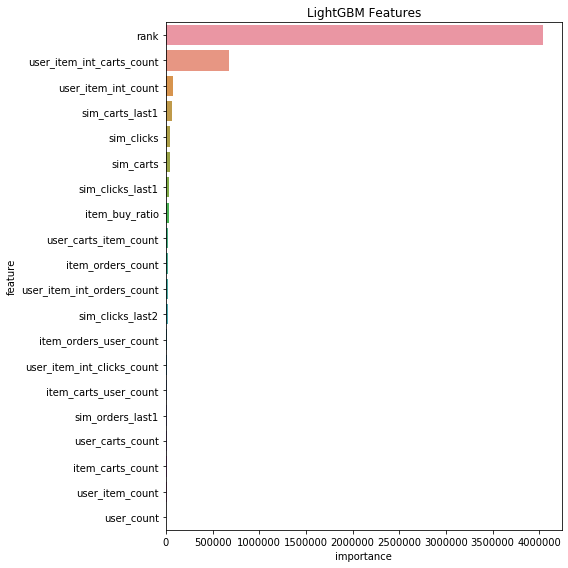

In [42]:
def print_gbm_model_feature_importance(model):
#     feature_names = model.feature_name()
    feature_names = features
#     importances = list(model.feature_importance())
    importances = list(model.feature_importances_)
    feature_importances = [(feature,round(importance)) for feature,importance in zip(feature_names,importances)]
    feature_importances = sorted(feature_importances,key=lambda x:x[1],reverse=True)
    #print(feature_importances)
    return feature_importances
import matplotlib.pyplot as plt
import seaborn as sns

feature_importance_df = []
for model in modellist_lgbrank:
    feature_importance_df_ = print_gbm_model_feature_importance(model)
    feature_importance_df_ = pd.DataFrame(feature_importance_df_)
    feature_importance_df_.columns = ["feature", "importance"]
    feature_importance_df.append(feature_importance_df_)
feature_importance_df = pd.concat(feature_importance_df)
feature_importance_df = feature_importance_df.groupby('feature')['importance'].mean().reset_index()

sss = feature_importance_df.sort_values(by="importance", ascending=False).head(20)

plt.figure(figsize=(8,8))
sns.barplot(x="importance", y="feature", 
            data=sss)
plt.title('LightGBM Features')
plt.tight_layout()

In [49]:
feature_importance_df.sort_values(by='importance',ascending=False)

,feature,importance
9,rank,48.8
27,user_item_int_carts_count,25.4
29,user_item_int_count,9.2
30,user_item_int_orders_count,4.0
6,item_orders_count,1.6
7,item_orders_user_count,1.2
23,user_clicks_count,1.0
13,sim_clicks_last1,1.0
26,user_item_count,1.0
0,item_buy_ratio,1.0


In [50]:
train.head()

,aid,rank,flag,session,type,label,user_count,user_item_count,user_buy_ratio,user_clicks_count,...,sim_clicks,sim_carts,sim_orders,sim_clicks_last1,sim_carts_last1,sim_orders_last1,sim_clicks_last2,sim_clicks_last3,sim_clicks_last5,sim_clicks_last10
0,11830,0.0,1.0,11098528,orders,1.0,1,1,1.0,1.0,...,1.000000,NaN,NaN,1.000000,NaN,NaN,1.000000,1.000000,1.000000,1.000000
1,77440,11.0,1.0,11098528,orders,0.0,1,1,1.0,1.0,...,0.776320,NaN,NaN,0.776320,NaN,NaN,0.776320,0.776320,0.776320,0.776320
2,92401,NaN,NaN,11098528,orders,1.0,1,1,1.0,1.0,...,0.385702,NaN,NaN,0.385702,NaN,NaN,0.385702,0.385702,0.385702,0.385702
3,135833,35.0,1.0,11098528,orders,0.0,1,1,1.0,1.0,...,0.848668,NaN,NaN,0.848668,NaN,NaN,0.848668,0.848668,0.848668,0.848668
4,205357,19.0,1.0,11098528,orders,0.0,1,1,1.0,1.0,...,0.884599,NaN,NaN,0.884599,NaN,NaN,0.884599,0.884599,0.884599,0.884599


In [41]:
train_pred = train[['session','aid','flag','rank','label']].copy()
train_pred['prob_lgb'] = oof_predictions

train_pred

,session,aid,flag,rank,label,prob_lgb
0,11098528,11830,1.0,0.0,1.0,0.591496
1,11098528,77440,1.0,11.0,0.0,0.006160
2,11098528,92401,NaN,NaN,1.0,0.999756
3,11098528,135833,1.0,35.0,0.0,0.002311
4,11098528,205357,1.0,19.0,0.0,0.000142
...,...,...,...,...,...,...
7350451,12899525,1725190,1.0,32.0,0.0,0.001868
7350452,12899525,1734890,1.0,7.0,0.0,0.004853
7350453,12899525,1760665,1.0,29.0,0.0,0.001759
7350454,12899525,1843621,1.0,47.0,0.0,0.000848


In [42]:
train_pred = train_pred.sort_values(by=['session','prob_lgb'],ascending=[True,False])
sub = train_pred[train_pred.flag==1].groupby('session')['aid'].apply(lambda x: list(x)[:20]).reset_index()
sub.columns = ['session','labels']
test_labels = pd.read_parquet('../input/otto-validation/test_labels.parquet')
test_labels = test_labels.loc[test_labels['type']==t]
test_labels = test_labels.merge(sub, how='left', on=['session'])
test_labels['hits'] = test_labels.apply(lambda df: len(set(df.ground_truth).intersection(set(df.labels))), axis=1)
test_labels['gt_count'] = test_labels.ground_truth.str.len().clip(0,20)
recall = test_labels['hits'].sum() / test_labels['gt_count'].sum()
recall

0.6572136238720983

In [1]:
train_pred = train_pred.sort_values(by=['session','rank'],ascending=[True,True])
sub = train_pred[train_pred.flag==1].groupby('session')['aid'].apply(lambda x: list(x)[:20]).reset_index()
sub.columns = ['session','labels']
test_labels = pd.read_parquet('../input/otto-validation/test_labels.parquet')
test_labels = test_labels.loc[test_labels['type']==t]
test_labels = test_labels.merge(sub, how='left', on=['session'])
test_labels['hits'] = test_labels.apply(lambda df: len(set(df.ground_truth).intersection(set(df.labels))), axis=1)
test_labels['gt_count'] = test_labels.ground_truth.str.len().clip(0,20)
recall = test_labels['hits'].sum() / test_labels['gt_count'].sum()
recall

0.6485054340366992
